Fast Radio Burst Training Notebook V3

by CHAMP

Description: Pytorch-Lightning + TIMM

Updated: 2023-03-16

Logs:
  - v1: Noob Code
  - v2: Refactor Code
  - v3: Add Dynamic Threshold Finding 

In [118]:
import os
from pathlib import Path

import math
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
# import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torch.optim.lr_scheduler import ReduceLROnPlateau, OneCycleLR
from torchvision.transforms import Compose, Resize, ToTensor, Normalize

from torchmetrics import Metric
from torchmetrics.classification import MultilabelF1Score

from pytorch_lightning.callbacks import (EarlyStopping, 
                                         ModelCheckpoint, 
                                         LearningRateMonitor, 
                                         Callback)
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning import Trainer, LightningModule

from PIL import Image
import matplotlib.pyplot as plt

import random

import timm

from tqdm import tqdm
# from timm.optim import Lookahead

In [119]:
timm.list_models("*coat*", pretrained=False)[:7]

['coat_lite_mini',
 'coat_lite_small',
 'coat_lite_tiny',
 'coat_mini',
 'coat_tiny',
 'coatnet_0_224',
 'coatnet_0_rw_224']

## CFG

In [120]:
class CFG:
    # data
    dataset_dir = Path("/home/superai052/super_workspace/Data_train/dataset")
    train_csv = dataset_dir / "train.csv"
    val_csv = dataset_dir / "val.csv"
    # test_csv = dataset_dir / "test.csv"
    
    # model
    model_name = "coatnet_0_rw_224"
    num_classes = 3
    learning_rate = 1e-5

    # trainer
    batch_size = 64
    shuffle = True
    num_workers = 10
    epoch = 15
    gpus = 1

    
    # weight and logger
    weight_dir = Path("weights")  # change only this one
    weight_dir.mkdir(parents=True, exist_ok=True)
    
    weight_num = len(list(weight_dir.iterdir()))  # count weight directory
    weight_name = f"{model_name}_e{epoch}_lr{learning_rate}"
    save_weight_dir = weight_dir / weight_name
    save_weight_path = save_weight_dir / f"{weight_name}.pth"

## Create Class

### Data

In [121]:
class FRBDataset(Dataset):
    def __init__(self, csv_path, transform=None):
        """
        Initialize the FRBDataset.

        Args:
            csv_path (str): Path to the CSV file containing image paths and labels.
            transform (callable, optional): Optional transform to be applied to the images.
        """
        self.df = pd.read_csv(csv_path)
        self.transform = transform

    def __len__(self):
        """
        Return the number of samples in the dataset.

        Returns:
            int: The number of samples in the dataset.
        """
        return len(self.df)

    def __getitem__(self, idx):
        """
        Get a sample from the dataset at the given index.

        Args:
            idx (int): Index of the sample to fetch.

        Returns:
            tuple: A tuple containing the image and its corresponding labels.
        """
        row = self.df.loc[idx]

        # Read the image using its absolute path
        image_path = row.path
        image = Image.open(image_path).convert("RGB")

        # Extract labels from the row
        labels = torch.tensor([row.pulse, row.broad, row.narrow], dtype=torch.float32)

        # Apply the transformation to the image, if specified
        if self.transform:
            image = self.transform(image)

        return image, labels

In [122]:
def unnormalize(image, mean, std):
    image_np = image.numpy().transpose((1, 2, 0))  # Convert tensor to NumPy array and rearrange channels
    image_np = (image_np * np.array(std)) + np.array(mean)  # Reverse normalization
    image_np = np.clip(image_np, 0, 1)  # Clip values to [0, 1] range
    return image_np

def visualize_transformed_images(dataset,
                                 mean,
                                 std, 
                                 num_images=9, 
                                 cols=3):
    rows = math.ceil(num_images / cols)
    random_img = random.sample(range(len(dataset)), num_images)
    
    _, axs = plt.subplots(rows, cols, figsize=(3 * cols, 3 * rows))
    for i, img_idx in enumerate(random_img):
        row, col = divmod(i, cols)
        image, labels = dataset[img_idx]
        
        image_np = unnormalize(image, mean, std)  # Unnormalize the image
        axs[row, col].imshow(image_np, vmin=0., vmax=1.)
        axs[row, col].set_title(f"Labels: {labels}")
        axs[row, col].axis('off')

    plt.tight_layout()
    plt.show()

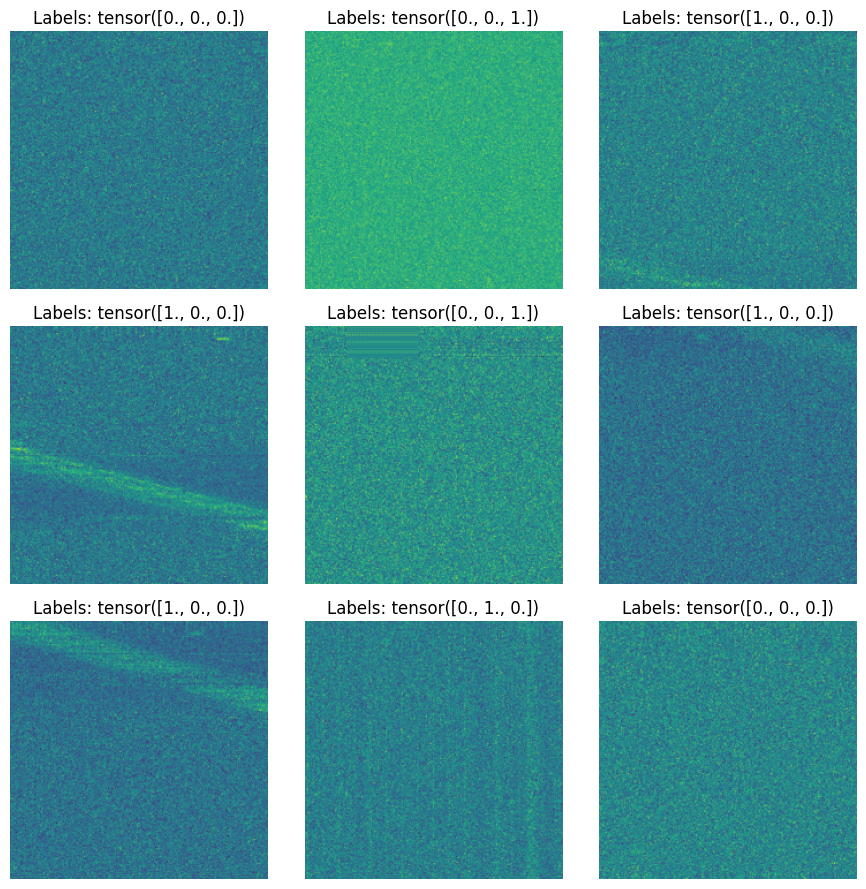

In [123]:
image_mean = [0.485, 0.456, 0.406]
image_std = [0.229, 0.224, 0.225]

transform = Compose([
    Resize((224, 224)),
    ToTensor(),
    Normalize(mean=image_mean, std=image_std),
])

train_dataset = FRBDataset(CFG.train_csv, 
                           transform=transform)
visualize_transformed_images(train_dataset, 
                             mean=image_mean,
                             std=image_std,
                             num_images=9, 
                             cols=3)

In [124]:
val_dataset = FRBDataset(CFG.val_csv, 
                         transform=transform)

visualize_transformed_images(val_dataset,
                             mean=image_mean,
                             std=image_std,
                             num_images=9, 
                             cols=3)

In [125]:
# test_dataset = FRBDataset(CFG.test_csv, 
#                           transform=transform)
# visualize_transformed_images(test_dataset, 
#                              mean=image_mean,
#                              std=image_std,
#                              num_images=9, 
#                              cols=3)

### Metric

In [126]:
class PulseRecall(Metric):
    """
    A custom metric class to calculate Pulse Recall for a specified class.
    """
    def __init__(self, class_idx=0, threshold=0.5):
        """
        Initialize the PulseRecall metric.

        Args:
            class_idx (int): The index of the class for which to calculate Pulse Recall.
            threshold (float): The threshold for converting probabilities to binary predictions.
        """
        super().__init__()
        self.class_idx = class_idx
        self.threshold = threshold

        # Initialize states for true positives and false negatives
        self.add_state("true_positives", default=torch.tensor(0), dist_reduce_fx="sum")
        self.add_state("false_negatives", default=torch.tensor(0), dist_reduce_fx="sum")

    def update(self, preds: torch.Tensor, target: torch.Tensor):
        """
        Update the state variables with new predictions and targets.

        Args:
            preds (torch.Tensor): Predicted probabilities for the current step.
            target (torch.Tensor): Ground truth labels for the current step.
        """
        # Check that the shapes of predictions and targets match
        assert preds.shape == target.shape

        # Binarize predictions based on the threshold
        preds = (preds > self.threshold).float()

        # Ensure targets are float tensors
        target = target.float()

        # Calculate true positives and false negatives for the specified class
        true_positives = torch.sum(preds[:, self.class_idx] * target[:, self.class_idx])
        false_negatives = torch.sum((1 - preds[:, self.class_idx]) * target[:, self.class_idx])

        # Update state variables
        self.true_positives += true_positives.long()
        self.false_negatives += false_negatives.long()

    def compute(self):
        """
        Compute the Pulse Recall metric based on the current state variables.

        Returns:
            torch.Tensor: The calculated Pulse Recall value.
        """
        # Compute pulse recall
        pulse_recall = self.true_positives / (self.true_positives + self.false_negatives)
        return pulse_recall


### Model

#### Multi-Layer Perceptron

In [127]:
class MLPLayer(nn.Module):
    """
    Multi-layer perceptron (MLP) layer with configurable input, output, and hidden sizes.
    
    Args:
        input_size (int): The number of input features for the MLP.
        output_size (int, optional): The number of output features for the MLP. Defaults to 3.
        hidden_sizes (list of int, optional): The sizes of the hidden layers in the MLP. Defaults to [512, 256].
    """
    def __init__(self, input_size, output_size=3, hidden_sizes=None, activation_fn=nn.ReLU, dropout_p=0.5, use_batch_norm=False):
        super(MLPLayer, self).__init__()
        if hidden_sizes is None:
            hidden_sizes = [512, 256]

        # Construct layer_sizes, which includes input, hidden, and output sizes
        layer_sizes = [input_size] + hidden_sizes + [output_size]

        # Initialize an empty list to store layers
        layers = []

        # Iterate through the layer sizes and create layers
        for i in range(len(layer_sizes) - 1):
            # Add a linear layer
            layers.append(nn.Linear(layer_sizes[i], layer_sizes[i+1]))

            # Add activation, dropout, and batch normalization only between hidden layers
            if i < len(layer_sizes) - 2:
                # Add activation function
                layers.append(activation_fn())

                # Add dropout layer
                layers.append(nn.Dropout(dropout_p))

                # Add batch normalization layer if use_batch_norm is True
                if use_batch_norm:
                    layers.append(nn.BatchNorm1d(layer_sizes[i + 1]))

        # Combine all layers into a Sequential container
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)

#### Timm

In [128]:
class TimmLightningModel(LightningModule):
    """
    A LightningModule that wraps a timm model with an additional MLP layer
    for multilabel classification tasks.
    """
    def __init__(self, 
                 model_name='resnet18',
                 pretrained=False, 
                 num_classes=3, 
                 learning_rate=1e-3,
                 hidden_dim=None):
        """
        Initialize the TimmLightningModel.

        Args:
            model_name (str): The name of the timm model to use.
            pretrained (bool): Whether to use pretrained weights for the timm model.
            num_classes (int): The number of output classes.
            learning_rate (float): The learning rate for the optimizer.
            hidden_dim (list, optional): A list of hidden layer sizes for the MLP layer.
        """
        super().__init__()

        # Initialize hyperparameters
        self.learning_rate = learning_rate
        self.num_classes = num_classes

        # Save hyperparameters for logging
        self.save_hyperparameters()

        # Create the base model
        self.model = timm.create_model(model_name, 
                                       pretrained=pretrained, 
                                       num_classes=0)

        # Create the MLP layer
        self.mlp = MLPLayer(input_size=self.model.num_features, 
                            output_size=num_classes,
                            hidden_sizes=hidden_dim)

        # Initialize the loss function
        self.loss_fn = nn.BCEWithLogitsLoss()

        # Initialize metrics
        self.__init_metrics()

    def configure_optimizers(self):
        """
        Configure the optimizer and learning rate scheduler for the module.

        Returns:
            dict: A dictionary containing the optimizer and learning rate scheduler.
        """
        # Create the base optimizer
        optimizer = torch.optim.AdamW(self.parameters(), 
                                          lr=self.learning_rate)
        # optimizer = Lookahead(base_optimizer)

        # Create the learning rate scheduler
        scheduler = ReduceLROnPlateau(optimizer,
                                      mode='max', 
                                      factor=0.1, 
                                      patience=10, 
                                      verbose=True)

        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "val_f1",
            }
        }

    def __init_metrics(self):
        """
        Initialize F1 and Pulse Recall metrics for train, val, and test phases.
        """
        self.metrics = {
            phase: {
                "f1": MultilabelF1Score(num_labels=self.num_classes,
                                        threshold=0.5,
                                        average='weighted',
                                        multidim_average='global'),
                "pulse_recall": PulseRecall()
            }
            for phase in ["train", "val", "test"]
        }

    def on_fit_start(self):
        """
        This method is called at the beginning of the fit (training) process.
        It moves the metrics to the same device as the input tensors for each phase.
        """
        phases = ["train", "val", "test"]

        for phase in phases:
            self.metrics[phase]["f1"].to(self.device)
            self.metrics[phase]["pulse_recall"].to(self.device)

    def forward(self, x):
        """
        Perform the forward pass through the model.

        Args:
            x (torch.Tensor): Input tensor with shape (batch_size, num_channels, height, width).

        Returns:
            torch.Tensor: Output tensor with shape (batch_size, num_classes).
        """
        x = self.model(x)
        x = self.mlp(x)
        return x

    @torch.no_grad()
    def predict(self, x, threshold=None):
        """
        Predict the probabilities or binary outcomes for the given input tensor.

        Args:
            x (torch.Tensor): Input tensor with shape (batch_size, num_channels, height, width).
            threshold (float, optional): Threshold for converting probabilities to binary predictions.
                                        If None, the function returns probabilities.

        Returns:
            torch.Tensor: Output tensor with probabilities or binary predictions.
        """
        # Move x variable to gpu
        x = x.to(self.device)
        
        # Compute logits using the forward pass
        logits = self.forward(x)

        # Convert logits to probabilities using the sigmoid function
        prob = torch.sigmoid(logits)

        # If a threshold is provided, convert probabilities to binary predictions
        if threshold is not None:
            prob = (prob > threshold).float()

        return prob

    def __run_step(self, batch, phase):
        """
        Run a single step for training, validation, or testing.

        Args:
            batch (tuple): A tuple containing input tensor and target tensor.
            phase (str): The phase of the model, either "train", "val", or "test".

        Returns:
            torch.Tensor: Loss value for the current step.
        """
        x, y = batch
        y_hat = self(x)

        # Calculate the loss
        loss = self.loss_fn(y_hat, y)

        # Log the metrics for the given phase
        self.log_metrics(phase, loss, torch.sigmoid(y_hat), y)

        return loss

    def training_step(self, batch, batch_idx):
        return self.__run_step(batch, phase="train")

    def validation_step(self, batch, batch_idx):
        return self.__run_step(batch, phase="val")

    def test_step(self, batch, batch_idx):
        return self.__run_step(batch, phase="test")

    def log_metrics(self, phase, loss, preds, target):
        """
        Log metrics for the given phase.

        Args:
            phase (str): The phase of the model, either "train", "val", or "test".
            loss (torch.Tensor): Loss value for the current step.
            preds (torch.Tensor): Predicted probabilities for the current step.
            target (torch.Tensor): Ground truth labels for the current step.
        """

        # Get the appropriate metrics based on the phase
        f1_metric = self.metrics[phase]["f1"]
        pulse_recall_metric = self.metrics[phase]["pulse_recall"]

        # Define a dictionary to store the metric keys for logging
        metric_keys = {
            "loss": f"{phase}_loss",
            "f1": f"{phase}_f1",
            "pulse_recall": f"{phase}_pulse_recall",
            "frb_accuracy": f"{phase}_frb_accuracy",
        }

        # Log the loss
        self.log(metric_keys["loss"], loss, on_step=False, on_epoch=True, logger=True, prog_bar=True)

        # Update and compute the F1 metric, then log it
        f1_metric.update(preds, target)
        accuracy = f1_metric.compute()
        self.log(metric_keys["f1"], accuracy, on_step=False, on_epoch=True, logger=True, prog_bar=True)

        # Update and compute the pulse recall metric, then log it
        pulse_recall_metric.update(preds, target)
        pulse_recall = pulse_recall_metric.compute()
        self.log(metric_keys["pulse_recall"], pulse_recall, on_step=False, on_epoch=True, logger=True, prog_bar=True)

        # Compute and log the FRB accuracy
        frb_accuracy = pulse_recall * accuracy
        self.log(metric_keys["frb_accuracy"], frb_accuracy, on_step=False, on_epoch=True, logger=True, prog_bar=True)

In [129]:
model = TimmLightningModel(
    model_name=CFG.model_name,
    num_classes=CFG.num_classes,
    learning_rate=CFG.learning_rate,
)
model

TimmLightningModel(
  (model): MaxxVit(
    (stem): Stem(
      (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (norm1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): SiLU(inplace=True)
      )
      (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (stages): Sequential(
      (0): MaxxVitStage(
        (blocks): Sequential(
          (0): MbConvBlock(
            (shortcut): Downsample2d(
              (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
              (expand): Conv2d(64, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
            )
            (pre_norm): BatchNormAct2d(
              64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): SiLU(inplace=True)
            )
            (down): Downsample2d(
              (pool

### Callbacks

#### EarlyStopping

In [130]:
early_stop_callback = EarlyStopping(
    monitor="val_f1",
    patience=3,
    mode="max",
    verbose=True,
)
early_stop_callback

#### ModelCheckpoint

In [131]:
checkpoint_callback = ModelCheckpoint(
    monitor="val_f1",
    mode="max",
    filename="{epoch:02d}-{val_f1:.4f}",
    save_top_k=1,
    verbose=True,
)
checkpoint_callback

#### LearningRateMonitor

In [132]:
class LearningRateLogger(Callback):
    def on__epoch_end(self, trainer, pl_module):
        lr = trainer.optimizers[0].param_groups[0]["lr"]
        pl_module.log("learning_rate", lr)

In [133]:
callbacks = [early_stop_callback, 
             checkpoint_callback, 
             LearningRateLogger()]

### Logger

In [134]:
logger = TensorBoardLogger(save_dir=CFG.weight_dir,
                           name=CFG.weight_name)
logger

## Training

In [135]:
train_loader = DataLoader(train_dataset, batch_size=CFG.batch_size, shuffle=CFG.shuffle, num_workers=CFG.num_workers)
val_loader = DataLoader(val_dataset, batch_size=CFG.batch_size, shuffle=CFG.shuffle, num_workers=CFG.num_workers)
# test_loader = DataLoader(test_dataset, batch_size=CFG.batch_size, shuffle=CFG.shuffle, num_workers=CFG.num_workers)

In [136]:
model = TimmLightningModel(
    model_name=CFG.model_name,
    num_classes=CFG.num_classes,
    learning_rate=CFG.learning_rate,
)

In [137]:
trainer = Trainer(
    max_epochs=CFG.epoch,
    # gpus=CFG.gpus,
    callbacks=callbacks,
    logger=logger
)

/home/superai052/.conda/envs/work/lib/python3.8/site-packages/lightning_fabric/plugins/environments/slurm.py:166: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/superai052/.conda/envs/work/lib/python3.8/site ...
  rank_zero_warn(
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/superai052/.conda/envs/work/lib/python3.8/site-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(


In [138]:
trainer.fit(
    model=model,
    train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True, num_workers=16, pin_memory=True),
    val_dataloader = DataLoader(val_dataset, batch_size=eval_batch_size, shuffle=False, num_workers=16, pin_memory=True)
    )

Missing logger folder: weights/coatnet_0_rw_224_e15_lr1e-05

  | Name    | Type              | Params
----------------------------------------------
0 | model   | MaxxVit           | 26.7 M
1 | mlp     | MLPLayer          | 525 K 
2 | loss_fn | BCEWithLogitsLoss | 0     
----------------------------------------------
27.2 M    Trainable params
0         Non-trainable params
27.2 M    Total params
108.770   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/superai052/.conda/envs/work/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:488: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/home/superai052/.conda/envs/work/lib/python3.8/site-packages/pytorch_lightning/trainer/call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


## Evaluate

In [ ]:
val_metrics = trainer.validate(model=model,
                               dataloaders=val_loader)

You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_f1             0.8562943339347839
    val_frb_accuracy        0.7896527051925659
        val_loss            0.14402346312999725
    val_pulse_recall        0.9221741557121277
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


### Find the best Threshold for each Class

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else "cpu"
model = model.to(device)
model.eval()
model.device

device(type='cuda', index=0)

In [ ]:
def gather_predictions_and_targets(model, val_loader):
    """
    Gather predictions and targets from a model and a validation DataLoader.

    Args:
        model (torch.nn.Module): The trained PyTorch model.
        val_loader (torch.utils.data.DataLoader): DataLoader for the validation dataset.

    Returns:
        tuple: A tuple containing the stacked prediction and target tensors.
    """
    preds = []
    actuals = []

    # Loop through the validation loader and gather predictions and targets
    for x, y in tqdm(val_loader):
        pred = model.predict(x).cpu()
        target = y

        preds.append(pred)
        actuals.append(target)

    # Stack all predictions and targets into single tensors
    preds = torch.vstack(preds)
    actuals = torch.vstack(actuals)

    return preds, actuals

# Gather the predictions and targets from the validation dataset
preds, actuals = gather_predictions_and_targets(model, val_loader)

# Print the shapes of the predictions and targets tensors
preds.shape, actuals.shape

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 124/124 [00:32<00:00,  3.80it/s]


(torch.Size([7935, 3]), torch.Size([7935, 3]))

In [ ]:
def compute_frb_accuracy(preds, actuals, thresholds):
    """
    Compute the FRB accuracy given predictions, actual targets, and thresholds.

    Args:
        preds (torch.Tensor): Predictions tensor.
        actuals (torch.Tensor): Actual targets tensor.
        thresholds (list): A list of thresholds for each class.

    Returns:
        float: The FRB accuracy (PulseRecall * Accuracy).
    """
    # Create a copy of the predictions tensor and apply the thresholds
    preds_copy = preds.clone()
    for i, threshold in enumerate(thresholds):
        preds_copy[:, i] = preds_copy[:, i] > threshold

    # Initialize the PulseRecall and MultilabelF1Score metrics
    pulse_recall = PulseRecall()
    accuracy = MultilabelF1Score(num_labels=3, threshold=0.5, average='weighted', multidim_average='global')

    # Update and compute the metrics
    pulse_recall.update(preds=preds_copy, target=actuals)
    pulse_recall_score = pulse_recall.compute()
    accuracy.update(preds=preds_copy, target=actuals)
    accuracy_score = accuracy.compute()

    # Return the FRB accuracy (PulseRecall * Accuracy)
    return pulse_recall_score * accuracy_score


def update_best_threshold(best_threshold, frb_accuracy, thresholds):
    """
    Update the best_threshold dictionary if the current FRB accuracy is better.

    Args:
        best_threshold (dict): A dictionary containing the best score and thresholds.
        frb_accuracy (float): The current FRB accuracy.
        thresholds (list): A list of thresholds for each class.
    """
    if frb_accuracy > best_threshold["score"]:
        best_threshold["score"] = frb_accuracy
        best_threshold["threshold"] = thresholds


# Initialize the best_threshold dictionary
best_threshold = {"score": 0, "threshold": [0, 0, 0]}

# Define the threshold range to search through
thresh_range = np.linspace(0.1, 1, 50)

# Loop through all possible combinations of thresholds for each class
for pulse_thresh in tqdm(thresh_range):
    for broad_thresh in thresh_range:
        for narrow_thresh in thresh_range:
            # Create a list of current thresholds for each class
            thresholds = [pulse_thresh, broad_thresh, narrow_thresh]

            # Calculate the FRB accuracy for the current combination of thresholds
            frb_accuracy = compute_frb_accuracy(preds, actuals, thresholds).item()

            # Update the best_threshold if the current combination is better
            update_best_threshold(best_threshold, frb_accuracy, thresholds)

# Print the best_threshold dictionary
best_threshold


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [02:50<00:00,  3.42s/it]


{'score': 0.8232704997062683,
 'threshold': [0.11836734693877551, 0.9448979591836735, 0.7612244897959184]}

In [ ]:
import json

# Set the path where the best_threshold JSON file will be saved
best_threshold_path = CFG.save_weight_dir / "best_thresh.json"

# Save the best_threshold dictionary to a JSON file
with open(best_threshold_path, "w") as f:
    json.dump(best_threshold, f)

print(open(best_threshold_path).read())

{"score": 0.8232704997062683, "threshold": [0.11836734693877551, 0.9448979591836735, 0.7612244897959184]}


## Save Model

In [ ]:
# CFG.model_dir.mkdir(parents=True, exist_ok=True)
torch.save(model.state_dict(), CFG.save_weight_path)